In [1]:
using Plots
using LaTeXStrings
using Roots
using LinearAlgebra

In [2]:
function f(p, k, δ)
    w = (4-k)/(2*k)
    γ = p/(1-p) 
    return δ*w - δ*(1- (1-δ)^2) - γ*(w - δ^2)*(1-δ)
end 

"""
    Roots for either case 
"""
function get_roots(p, k, isBoom)
    if isBoom 
        function h(x) 
            pred = pred_delta(x,p,k)
            if pred > 1 
                return 2
            end 
            return pred_delta(x, p, k) - x
        end 
        return find_zeros(h, (0,1)) 
    else 
        g(x) = f(p,k, x) 
        return find_zeros(g, (0,1))
    end 
end 

""" 
    Find the roots in the presence of seeding 
    in the boom case 
""" 
function get_roots_seeded(p, k, n_seeds)
    function h(x) 
        q_t = q_roots(x, k, true)[end]
        q_f = q_roots(x, k, false)[end]
        if q_f == 0.0 || q_t == 0
            return 2 
        end
        q_t = 1 - (1 - q_t)^n_seeds
        q_f = 1 - (1 - q_f)^n_seeds
        return (p*q_t / (p*q_t +  (1-p)*q_f)) - x
    end
    return find_zeros(h, (0,1))
end 


"""
    Roots for q equation 
"""
function q_roots(δ, k, α)
    if α 
        β = 0.25 + 0.5*(2-δ)*δ 
    else 
        β = 0.25 + 0.5*δ^2 
    end 
    g(x) = x - β + β*(1-x)^k 
    return find_zeros(g, (0,1))
end 

function which_case(p, k)
    bt = beta_t(p)
    bf = beta_f(p)
    if bt*k < 1 
        return 0 
    elseif bf < 1 
        return 1 
    else 
        return 2 
    end 
end 


"""
    Given delta_in, p, k output predicted delta in boom case 
"""
function pred_delta(delta, p,  k)
    qt = q_roots(delta, k, true)[end]
    qf = q_roots(delta,k, false)[end]
    ## Problem if  qt = qf = 0 
    if qt==0 && qf == 0 
        return 2
    end 
    d_pred = (p*qt)/(p*qt + (1-p)*qf)
    return d_pred 
end



function isValidBust(delta, k)
    if beta_t(delta)*k <= 1 
        return delta 
    else 
        return NaN 
    end 
end 

function joint_plot!(x_data, y_data, label, shape, color, step=4)
    n = length(x_data)
    range_1 = filter(x-> x%step==0, 1:n)
    range_2 = filter(x->x%step!=0, 1:n)
    plot!(x_data[range_2], y_data[range_2], label="", c=color)
    plot!(x_data[range_1], y_data[range_1], 
    label=label, c=color, marker=shape, xlims=(minimum(x_data), maximum(x_data)))
    #plot!(, arr1,label=L"x^2",  c=cols[1], marker=markers[1])
end 

beta_t(x) = 0.25 + 0.5*(2-x)*x
beta_f(x) = 0.25 + 0.5*x^2 


beta_f (generic function with 1 method)

In [3]:
p = 0.1
d_range = 0.001 * (1:1000)
h_range = 0.01 * (1:100)
out_delta = zeros(1000)
k = 5 + (1/3)
for i=1:1000 
    x =  pred_delta(i/1000, p,k)
    x = x/(1-x)
    out_delta[i] = x 
    if( x >= 1)
        out_delta[i] = NaN 
    else 
        out_delta[i] = x 
    end 
end 


## plot style things

In [3]:
range_100 = 1:99
range_1000 = (1:999) .* 0.001
p_range = (1:99) .* 0.01

0.01:0.01:0.99

In [4]:
colors = distinguishable_colors(5, [RGB(1,1,1), RGB(0,0,0)], dropseed=true)
## ^ 6 distinguishable_colors from black and white 
names = [L"1.33", L"2", L"3", L"4", L"\kappa\to\infty"]
## names
markers = [:circle, :cross, :diamond, :rect, :hexagon]


5-element Vector{Symbol}:
 :circle
 :cross
 :diamond
 :rect
 :hexagon

## delta collection

In [4]:
range_100 = 1:99 
kapps = [6]
boom_pvdelt = zeros(5, 99)
for i=1:99 
    for j=1:length(kapps)
        r = get_roots(i/100, kapps[j], true)
        if length(r) == 0
            boom_pvdelt[j,i] = NaN 
        else 
            # qf = q_roots(r[end], kapps[j], false)
            # if length(qf) == 2
            boom_pvdelt[j, i] = r[end]
            # else 
            #     boom_pvdelt[j,i] = NaN
            # end 
        end 
    end 
end 

function high_k_roots(p)
    function f(x) 
        bt = beta_t(x)
        bf = beta_f(x) 
        return x - ((p*bt)/(p*bt + (1-p)*bf))
    end 
    return find_zeros(f, (0,1))
end 

for i=1:99 
    p = i/100
    boom_pvdelt[5,i] = high_k_roots(p)[end]
end 

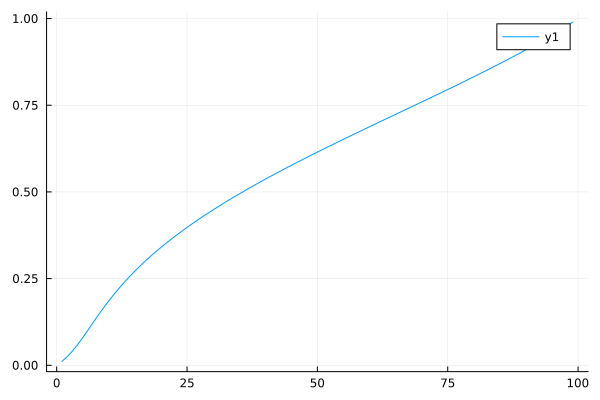

In [7]:
plot(1:99, boom_pvdelt[1, 1:99])

In [28]:
d = boom_pvdelt[1,1]
qt = q_roots(d, kapps[1], true)[end]
qf = q_roots(d, kapps[1], false)[end]
t1 = 0.01 * qt 
t2 = 0.99 * qf 
t1 / (t1 + t2 ), d

(1.0, 0.9999995059215864)

## Attribute collection
### Engagment 

In [30]:
engage_data = zeros(5,99)
for i=1:99
    for j=1:5
        delta = boom_pvdelt[j, i]
        engage_data[j,i] = delta*beta_t(delta) + (1-delta)*beta_f(delta)
    end 
end 

### Volume

In [31]:
volume_data = NaN * ones(5,99)
for i=1:99 
    for j=1:4
        if isnan(boom_pvdelt[j,i])
            volume_data[j,j] = NaN 
        else 
            p = i/100
            q_t = q_roots(boom_pvdelt[j,i], kapps[j], true)[end]
            q_f = q_roots(boom_pvdelt[j,i], kapps[j], false)[end]
            volume_data[j,i] = q_t*p + q_f*(1-p)
        end 
    end 
    p = i/100
    q_t = beta_t(boom_pvdelt[5,i])
    q_f = beta_f(boom_pvdelt[5,i])
    volume_data[5,i] = q_t*p + q_f*(1-p)   
end 


### Sensitivit and Specificity

In [32]:
sensit_data = NaN*ones(5, 99)
specit_data = NaN*ones(5,99)
for i=1:99
    for j=1:4
        if isnan(boom_pvdelt[j,i])
            sensit_data[j,j] = NaN 
            specit_data[j,i] = NaN 
            continue
        end 
        delta = boom_pvdelt[j,i]
        if isnan(delta)
            sensit_data[j, i] = NaN 
            specit_data[j, i] = NaN
            continue 
        end 
        sensit_data[j, i] = 1 - q_roots(delta, kapps[j], false)[end]
        specit_data[j, i] = q_roots(delta, kapps[j], true)[end]
    end 
    delta = boom_pvdelt[5,i] 
    sensit_data[5, i] = 1 - beta_f(delta)
    specit_data[5, i] = beta_t(delta)
end 



## Plots

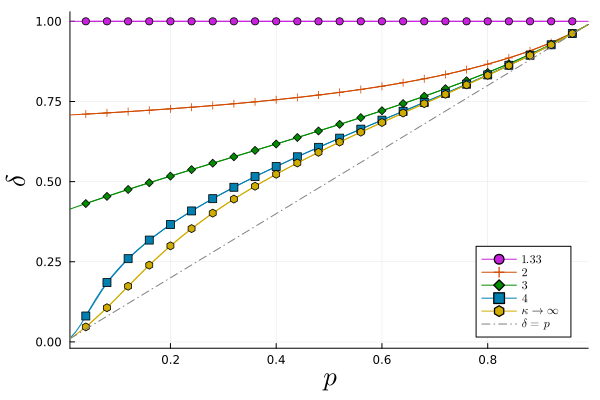

In [33]:
plot()
for j=1:5
    joint_plot!(p_range, boom_pvdelt[j,:], names[j], markers[j], colors[j])
end 
xlabel!(L"p",labelfontsize=18)

ylabel!(L"$\delta$")
plot!(p_range, p_range, ls=:dashdot, c="gray", label=L"\delta=p")
## q^\mathsf{T} 
plot!(legend=:bottomright)
#savefig("misinfo_images/p_vs_delta.pdf")

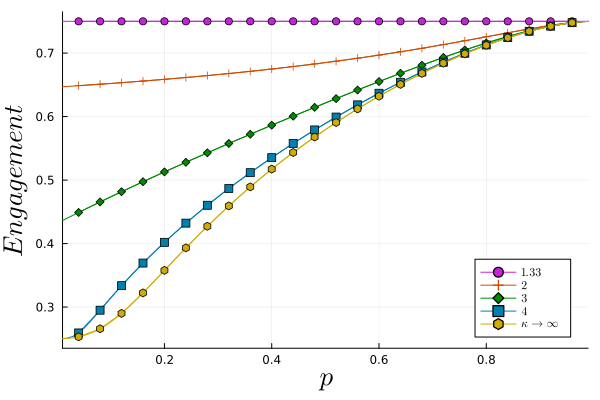

In [34]:
plot()
for j=1:5
    joint_plot!(p_range, engage_data[j,:], names[j], markers[j], colors[j])
end 
xlabel!(L"p",labelfontsize=18)
ylabel!(L"$Engagement$")
## q^\mathsf{T} 
plot!(legend=:bottomright)
#savefig("misinfo_images/engage.pdf")

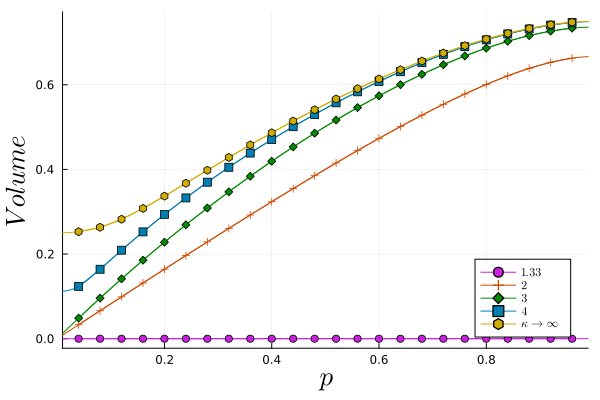

In [35]:
plot()
for j=1:5
    joint_plot!(p_range, volume_data[j,:], names[j], markers[j], colors[j])
end 

xlabel!(L"p",labelfontsize=18)
ylabel!(L"Volume")
## q^\mathsf{T} 
plot!(legend=:bottomright)
#savefig("misinfo_images/volume.pdf")

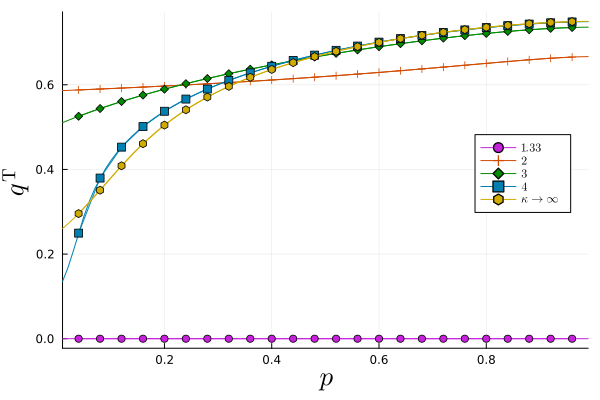

In [36]:
plot()
for j=1:5
    joint_plot!(p_range, specit_data[j,:], names[j], markers[j], colors[j])
end 
xlabel!(L"p")
ylabel!(L"$q^\mathsf{T}$", labelfontsize=18)
## q^\mathsf{T} 
plot!(legend=:right)
#savefig("misinfo_images/specit.pdf")


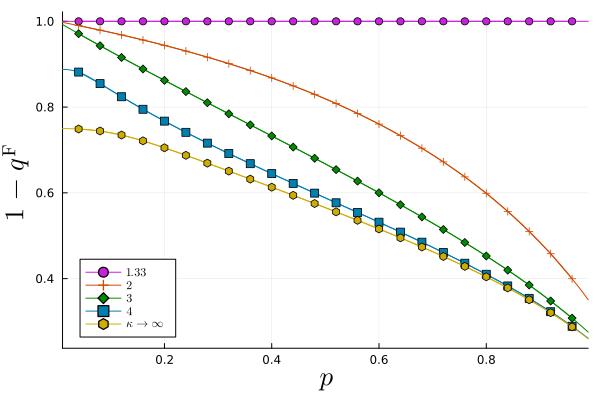

In [37]:
plot()
for j=1:5
    joint_plot!(p_range, sensit_data[j,:], names[j], markers[j], colors[j])
end 

xlabel!(L"p",labelfontsize=18)
ylabel!(L"1-q^\mathsf{F}")
## q^\mathsf{T} 
yaxis!(lw=20 )
plot!(legend=:bottomleft)
#savefig("misinfo_images/sensit.pdf")


# 3 Equilibrum 

In [101]:
p = 0.1
k = 6
function equil_curve!(p, k, res)
    for i = 1:999
        d_in = i/1000
        bt = beta_t(d_in)
        bf = beta_f(d_in) 
        if k*bt < 1 ## bust case
             t = p/(1- k*bt)
        #     b = (1-p) / (1-k*bf) 
        #     res[i] = t/(b+t)
        elseif k*bf > 1  ##boom case 
            res[i] = pred_delta(d_in, p, k)
        else ## Mixed case 
            res[i] = 1
        end 
    end 
end 
range_1000 = (1/1000) * (1:999)
answer13 = NaN*ones(999)
answer15 = NaN*ones(999)
answer2  = NaN*ones(999)
k = 5
equil_curve!(p, 1.3, answer13)
equil_curve!(p, 1.5, answer15)
equil_curve!(p, k, answer2)

#v = sqrt( (2/k) - (1/2))
kmax = -(4/(-3 + sqrt(3)))
v2 = (1/2)*(sqrt(3)-1)
answer15
range_1000

0.001:0.001:0.999

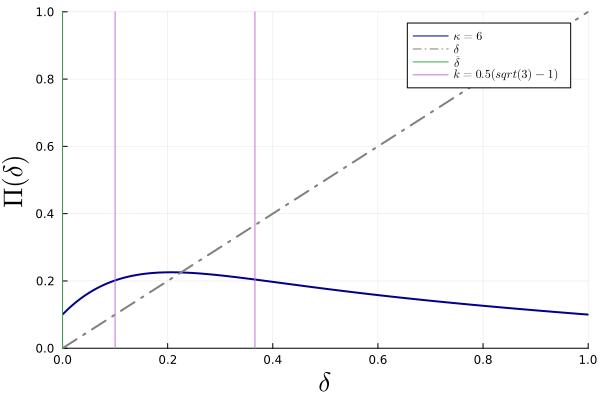

In [102]:
gr()
plot() 
c = "blue4"

plot(range_1000, answer2, label=L"\kappa=6", c=c, lw=2)
plot!(range_1000, range_1000, label=L"\delta",c="gray", ls=:dashdot, lw=2,legend= :bottom)
vline!([v], label=L"\bar{\delta}")
vline!([v2,p], label=L"k=0.5(sqrt(3)-1)")
xlabel!(L"\delta", labelfontsize=18)
ylabel!(L"\Pi(\delta)")
plot!(xlims=(0,1), ylims=(0,1),legend=true)
# #savefig("misinfo_images/equil_k15_no_leg.pdf")
# plot!(range_1000, answer2, label=L"\Pi(\delta)",c=c, lw=2)
# plot!(range_1000, range_1000, label=L"\delta",c="gray", ls=:dashdot, lw=2,legend= :bottom)
# xlabel!(L"\delta",labelfontsize=18)
# ylabel!(L"\Pi(\delta)")
# plot!(xlims=(0,1), ylims=(0,1),legend=false)
# #savefig("misinfo_images/equil_k2_no_leg.pdf")
# plot!(range_1000, answer13, label=L"\Pi(\delta)", c=c, lw=2)
# plot!(range_1000, range_1000, label=L"\delta",c="gray", ls=:dashdot, lw=2,legend= :bottom)
# xlabel!(L"\delta",labelfontsize=18)
# ylabel!(L"\Pi(\delta)")
# plot!(xlims=(0,1), ylims=(0,1),legend=true)

#savefig("misinfo_images/equil/_k13_no_leg.pdf")

'# Surface 

In [120]:
plot

plot (generic function with 4 methods)

In [22]:
range_100 = 1:99 
kapps1 = LinRange(1.5,4, 20)
surface_data = zeros(20,99)
for i=1:99 
    for j=1:20
        r = get_roots(i/100, kapps1[j], true)
        if length(r) == 0
            surface_data[j,i] = NaN 
        else 
            # qf = q_roots(r[end], kapps[j], false)
            # if length(qf) == 2
            surface_data[j, i] = r[end]
            # else 
            #     boom_pvdelt[j,i] = NaN
            # end 
        end 
    end 
end 



InterruptException: InterruptException:

In [ ]:
sheet = zeros(20,99)
for i=1:99
    sheet[:, i] .= i/100
end 

In [ ]:
plotlyjs()
plot()

surface!(range_100, kapps1, sheet, c="gray")
surface!(range_100, kapps1, surface_data)
xlabel!("p")
ylabel!("k")

misinformation in news about covid and elections
studies quantifying levels of misinformation 
What is being done in practice, efficafacy, drawbacks, sideeffects 
    detection and labeling 
    fact checking,
    prompting,
    immunization,
    labeling and removing 



## Multiple seeds 

In [ ]:
n_seeds = [1,2,4,8]
kappas = [2,3,4,5]
p_range = 0.01 * (1:100)
seed_results = zeros(length(kappas), length(n_seeds), 100)

In [22]:


for i=1:length(kappas)
    println("Iteration", i )
    for j=1:length(n_seeds)
        for k=1:100
            p = k / 100 
            r = get_roots_seeded(p, kappas[i], n_seeds[j])
            if  length(r)==0
                seed_results[i,j,k] = NaN 
            else 
                seed_results[i,j,k] = r[end]
            end 
        end 
    end 
end  

Iteration4


In [51]:
# p vs equilbrium delta 

plot(p_range, seed_results[1, 1, :], label="1 seed")
plot!(p_range, seed_results[1, 2, :], label="2 seed")
plot!(p_range, seed_results[1, 3, :], label="4 seed")
plot!(p_range, seed_results[1, 4, :], label="8 seed")

ylabel!(L"Equil. \delta")
xlabel!("p")
title!(L"$\kappa =2$, equilbrium $\delta$ vs p")
savefig("images/delta_vs_p_seeds.png")

"/home/calvinlinux/projects/PeerFilteringMisinfo/images/delta_vs_p_seeds.png"

In [52]:
## log(filtering effect) vs p. kappa fixed

plot(p_range, log.(seed_results[1, 1, :] ./ p_range), label="1 seed")
plot!(p_range, log.(seed_results[1, 2, :] ./ p_range), label="2 seed")
plot!(p_range, log.(seed_results[1, 3, :] ./ p_range) , label="4 seed")
plot!(p_range, log.(seed_results[1, 4, :] ./ p_range), label="8 seed")

ylabel!(L"Equil. \delta")
xlabel!("p")
title!(L"$\kappa =2$, equilbrium $\delta$ vs p")
savefig("images/log(filtering)_vs_p_seeds.png")

"/home/calvinlinux/projects/PeerFilteringMisinfo/images/log(filtering)_vs_p_seeds.png"

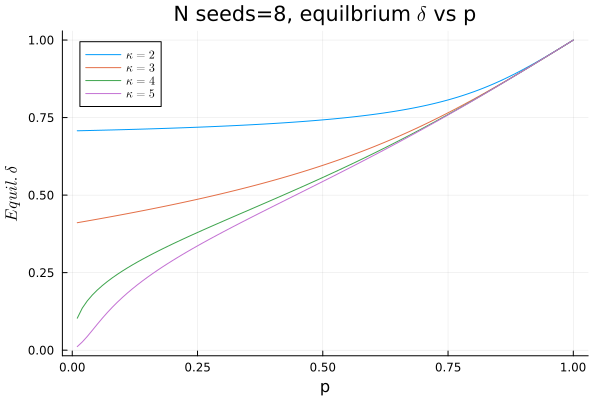

In [49]:
# equilbrium delta vs p. seeds fixed 
plot(p_range, seed_results[1, 3, :], label=L"\kappa =2")
plot!(p_range, seed_results[2, 3, :], label=L"\kappa = 3")
plot!(p_range, seed_results[3, 3, :], label=L"\kappa = 4")
plot!(p_range, seed_results[4, 3, :], label=L"\kappa = 5")

ylabel!(L"Equil. \delta")
xlabel!("p")
title!(L"N seeds=8, equilbrium $\delta$ vs p")
savefig("images/delta_vs_p_kappa.png")

In [54]:
##  log(filtering effect) vs p. n seeds fixed 
plot(p_range, log.(seed_results[1, 3, :] ./ p_range), label=L"\kappa =2")
plot!(p_range, log.(seed_results[2, 3, :] ./ p_range), label=L"\kappa = 3")
plot!(p_range, log.(seed_results[3, 3, :] ./ p_range), label=L"\kappa = 4")
plot!(p_range, log.(seed_results[4, 3, :] ./ p_range), label=L"\kappa = 5")

ylabel!(L"Equil. \delta")
xlabel!("p")
title!(L"N seeds=8, equilbrium $\delta$ vs p")
savefig("images/log(filtering)_vs_p_kappa.png")

"/home/calvinlinux/projects/PeerFilteringMisinfo/images/log(filtering)_vs_p_kappa.png"